# 🎓 Session 3: Implementing a GPT Model from Scratch

**Workshop: Build a Large Language Model From Scratch**  
**Duration**: 3 hours (9:30 AM - 12:30 PM)  
**Day 2**

**Instructor Notes**: 📢 indicates what to say, 💡 indicates key points to emphasize

---

## 📋 Session Overview

| Time | Topic | Type |
|------|-------|------|
| 9:30 - 9:45 | Day 1 Recap | Review |
| 9:45 - 10:30 | GPT Architecture Overview | Theory + Code |
| 10:30 - 10:45 | Break | - |
| 10:45 - 11:45 | Building GPT Components | Hands-on |
| 11:45 - 12:30 | Complete GPT Model + Generation | Hands-on |

---
# Part 1: Day 1 Recap (15 min)
---

## 📢 Instructor Script

> "Good morning and welcome to Day 2! Yesterday we learned:
> 1. How to convert text to tokens (tokenization)
> 2. How embeddings represent tokens as vectors
> 3. How attention lets tokens 'look at' each other
> 
> Today, we put it ALL together to build a complete GPT model!"

In [1]:
# Quick Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import tiktoken
import matplotlib.pyplot as plt

print(f"PyTorch: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print("\n✅ Ready for Day 2!")

PyTorch: 2.7.1+cpu
Device: cpu

✅ Ready for Day 2!


---
# Part 2: GPT Architecture Overview (45 min)
---

## 📢 Instructor Script
> "Let me show you the big picture of GPT. It's simpler than you might think!"

## 🏗️ GPT Architecture

```
┌─────────────────────────────────────────┐
│           Token Embeddings              │  ← Position in vocabulary
│         + Position Embeddings           │  ← Position in sequence
└─────────────────────────────────────────┘
                    ↓
┌─────────────────────────────────────────┐
│     ┌─────────────────────────────┐     │
│     │   Layer Normalization       │     │
│     └─────────────────────────────┘     │
│                   ↓                     │
│     ┌─────────────────────────────┐     │
│     │   Multi-Head Attention      │     │  ← From Session 2!
│     └─────────────────────────────┘     │
│                   ↓ (+residual)         │
│     ┌─────────────────────────────┐     │
│     │   Layer Normalization       │     │
│     └─────────────────────────────┘     │
│                   ↓                     │
│     ┌─────────────────────────────┐     │
│     │   Feed-Forward Network      │     │  ← Simple MLP
│     └─────────────────────────────┘     │
│                   ↓ (+residual)         │
│         TRANSFORMER BLOCK × N           │  ← Repeat N times!
└─────────────────────────────────────────┘
                    ↓
┌─────────────────────────────────────────┐
│       Final Layer Normalization         │
└─────────────────────────────────────────┘
                    ↓
┌─────────────────────────────────────────┐
│     Linear Layer (to vocab size)        │  ← Predict next token!
└─────────────────────────────────────────┘
```

## 📊 GPT-2 Model Configurations

📢 **Say this:**
> "GPT-2 comes in 4 sizes. We'll build the smallest (124M) which is still impressive!"

| Model | Parameters | Layers | Heads | Embedding Dim |
|-------|-----------|--------|-------|---------------|
| GPT-2 Small | 124M | 12 | 12 | 768 |
| GPT-2 Medium | 355M | 24 | 16 | 1024 |
| GPT-2 Large | 774M | 36 | 20 | 1280 |
| GPT-2 XL | 1.5B | 48 | 25 | 1600 |

In [2]:
# GPT-2 Small Configuration
GPT_CONFIG_124M = {
    "vocab_size": 50257,      # GPT-2 vocabulary size
    "context_length": 1024,   # Maximum sequence length
    "emb_dim": 768,           # Embedding dimension
    "n_heads": 12,            # Number of attention heads
    "n_layers": 12,           # Number of transformer blocks
    "drop_rate": 0.1,         # Dropout rate
    "qkv_bias": False         # Use bias in Q, K, V projections?
}

print("GPT-2 Small Configuration:")
for key, value in GPT_CONFIG_124M.items():
    print(f"  {key}: {value}")

GPT-2 Small Configuration:
  vocab_size: 50257
  context_length: 1024
  emb_dim: 768
  n_heads: 12
  n_layers: 12
  drop_rate: 0.1
  qkv_bias: False


---
## ☕ BREAK (10:30 - 10:45)
---

---
# Part 3: Building GPT Components (60 min)
---

📢 **Say this:**
> "Now let's build each component from the bottom up. We'll start with Layer Normalization, then Feed-Forward, then the Transformer Block."

## 1️⃣ Layer Normalization

📢 **Say this:**
> "Layer Normalization stabilizes training by normalizing the activations. Unlike Batch Norm, it normalizes across features, not the batch."

💡 **Formula:**
$$\text{LayerNorm}(x) = \gamma \cdot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$$

In [3]:
class LayerNorm(nn.Module):
    """Layer Normalization with learnable scale and shift."""
    
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(emb_dim))   # γ (gamma)
        self.shift = nn.Parameter(torch.zeros(emb_dim))  # β (beta)
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [4]:
# Test Layer Normalization
torch.manual_seed(42)
layer_norm = LayerNorm(768)

# Create sample input with high variance
sample = torch.randn(2, 4, 768) * 10 + 5  # mean ~5, std ~10
normalized = layer_norm(sample)

print(f"Before LayerNorm - Mean: {sample.mean():.4f}, Std: {sample.std():.4f}")
print(f"After LayerNorm  - Mean: {normalized.mean():.4f}, Std: {normalized.std():.4f}")

Before LayerNorm - Mean: 5.1056, Std: 10.0506
After LayerNorm  - Mean: -0.0000, Std: 1.0001


## 2️⃣ GELU Activation Function

📢 **Say this:**
> "GPT uses GELU instead of ReLU. GELU is smoother and works better for transformers."

💡 **GELU vs ReLU:**
- ReLU: max(0, x) - sharp cutoff at 0
- GELU: x · Φ(x) - smooth, probabilistic cutoff

In [5]:
class GELU(nn.Module):
    """Gaussian Error Linear Unit activation."""
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

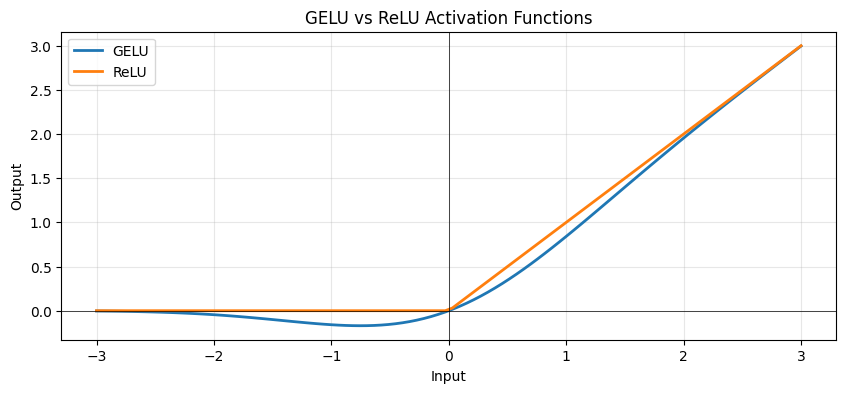

In [6]:
# Visualize GELU vs ReLU
x = torch.linspace(-3, 3, 100)
gelu = GELU()

plt.figure(figsize=(10, 4))
plt.plot(x, gelu(x), label='GELU', linewidth=2)
plt.plot(x, F.relu(x), label='ReLU', linewidth=2)
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
plt.legend()
plt.title('GELU vs ReLU Activation Functions')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid(True, alpha=0.3)
plt.show()

## 3️⃣ Feed-Forward Network (MLP)

📢 **Say this:**
> "After attention, we pass through a simple MLP. It expands the dimension by 4x, applies GELU, then projects back."

```
768 → 3072 (×4) → GELU → 3072 → 768
```

In [7]:
class FeedForward(nn.Module):
    """Feed-Forward Network in Transformer block."""
    
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
            nn.Dropout(cfg["drop_rate"])
        )
    
    def forward(self, x):
        return self.layers(x)

In [8]:
# Test Feed-Forward
ffn = FeedForward(GPT_CONFIG_124M)
sample = torch.randn(2, 4, 768)
output = ffn(sample)

print(f"Input shape: {sample.shape}")
print(f"Output shape: {output.shape}")

# Count parameters
ffn_params = sum(p.numel() for p in ffn.parameters())
print(f"\nFeed-Forward parameters: {ffn_params:,}")
print(f"  Linear 1: 768 × 3072 + 3072 = {768 * 3072 + 3072:,}")
print(f"  Linear 2: 3072 × 768 + 768 = {3072 * 768 + 768:,}")

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])

Feed-Forward parameters: 4,722,432
  Linear 1: 768 × 3072 + 3072 = 2,362,368
  Linear 2: 3072 × 768 + 768 = 2,360,064


## 4️⃣ Multi-Head Attention (from Session 2)

In [9]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Causal Self-Attention."""
    
    def __init__(self, d_in, d_out, context_length, num_heads, dropout=0.0, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    
    def forward(self, x):
        batch_size, seq_len, d_in = x.shape
        
        Q = self.W_query(x)
        K = self.W_key(x)
        V = self.W_value(x)
        
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        attn_scores = Q @ K.transpose(-2, -1) / (self.head_dim ** 0.5)
        attn_scores = attn_scores.masked_fill(
            self.mask[:seq_len, :seq_len].bool(), float('-inf')
        )
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = attn_weights @ V
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_out)
        
        return self.out_proj(context)

## 5️⃣ Transformer Block

📢 **Say this:**
> "Now we combine attention, FFN, and layer norm into one Transformer Block. Notice the residual connections - they're crucial!"

```
x → LayerNorm → MultiHeadAttn → + → LayerNorm → FFN → + → output
     ↑                          ↑              ↑        ↑
     └──────── (residual) ──────┘     └──── (residual)──┘
```

In [10]:
class TransformerBlock(nn.Module):
    """A single Transformer block (GPT-style)."""
    
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        # Attention block with residual
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        # FFN block with residual
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x

In [11]:
# Test Transformer Block
torch.manual_seed(42)
block = TransformerBlock(GPT_CONFIG_124M)

sample = torch.randn(2, 4, 768)
output = block(sample)

print(f"Input shape: {sample.shape}")
print(f"Output shape: {output.shape}")

block_params = sum(p.numel() for p in block.parameters())
print(f"\nTransformer Block parameters: {block_params:,}")

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])

Transformer Block parameters: 7,085,568


---
# Part 4: Complete GPT Model (45 min)
---

## 🎯 The Full GPT Model

📢 **Say this:**
> "Now for the grand finale! We stack everything together into the complete GPT model."

In [12]:
class GPTModel(nn.Module):
    """Complete GPT Model."""
    
    def __init__(self, cfg):
        super().__init__()
        
        # Token and position embeddings
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Transformer blocks
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        
        # Final layer norm and output head
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        
        # Get embeddings
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        
        # Pass through transformer blocks
        x = self.trf_blocks(x)
        
        # Final norm and project to vocabulary
        x = self.final_norm(x)
        logits = self.out_head(x)
        
        return logits

In [13]:
# Create GPT model!
torch.manual_seed(42)
model = GPTModel(GPT_CONFIG_124M)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\n🎉 Total GPT-2 Small Parameters: {total_params:,}")
print(f"   That's {total_params / 1e6:.1f} million parameters!")


🎉 Total GPT-2 Small Parameters: 163,009,536
   That's 163.0 million parameters!


In [14]:
# Test forward pass
tokenizer = tiktoken.get_encoding("gpt2")
text = "Hello, world!"
token_ids = tokenizer.encode(text)
input_tensor = torch.tensor(token_ids).unsqueeze(0)  # Add batch dimension

print(f"Input text: '{text}'")
print(f"Token IDs: {token_ids}")
print(f"Input tensor shape: {input_tensor.shape}")

# Forward pass
with torch.no_grad():
    logits = model(input_tensor)

print(f"\nOutput logits shape: {logits.shape}")
print(f"This is: (batch_size=1, seq_len={len(token_ids)}, vocab_size={GPT_CONFIG_124M['vocab_size']})")

Input text: 'Hello, world!'
Token IDs: [15496, 11, 995, 0]
Input tensor shape: torch.Size([1, 4])

Output logits shape: torch.Size([1, 4, 50257])
This is: (batch_size=1, seq_len=4, vocab_size=50257)


## 🔮 Text Generation!

📢 **Say this:**
> "Now let's generate text! We'll predict one token at a time, add it to the input, and repeat. This is called **autoregressive generation**."

In [15]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    """Generate text one token at a time."""
    for _ in range(max_new_tokens):
        # Crop to context window
        idx_cond = idx[:, -context_size:]
        
        # Get predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus on last token's prediction
        logits = logits[:, -1, :]  # (batch, vocab_size)
        
        # Get token with highest probability
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        # Append to sequence
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [16]:
# Generate text (with random weights - will be gibberish!)
start_text = "Hello, I am"
start_ids = tokenizer.encode(start_text)
start_tensor = torch.tensor(start_ids).unsqueeze(0)

print(f"Starting text: '{start_text}'")
print(f"Starting tokens: {start_ids}\n")

# Generate 20 new tokens
generated = generate_text_simple(
    model, 
    start_tensor, 
    max_new_tokens=20,
    context_size=GPT_CONFIG_124M["context_length"]
)

generated_text = tokenizer.decode(generated[0].tolist())
print(f"Generated text: '{generated_text}'")
print("\n💡 It's gibberish because the model has random weights!")
print("   We'll fix this by loading pretrained weights in Session 4!")

Starting text: 'Hello, I am'
Starting tokens: [15496, 11, 314, 716]

Generated text: 'Hello, I am authority rainbowriganBrave lobster Tian surprisinglyabul CertainGS formallyrait 239berry joking Visitors polic procession inter firing'

💡 It's gibberish because the model has random weights!
   We'll fix this by loading pretrained weights in Session 4!


## 🎲 Adding Randomness: Temperature Sampling

📢 **Say this:**
> "Using argmax always picks the most likely token - boring! We can add randomness with **temperature sampling**."

💡 **Temperature:**
- Low (0.1-0.5): More deterministic, focused
- Medium (0.7-0.9): Balanced
- High (1.0+): More random, creative

In [17]:
def generate_text(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=None):
    """Generate text with temperature and optional top-k sampling."""
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :]
        
        # Apply temperature
        if temperature > 0:
            logits = logits / temperature
            
            # Optional: top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')
            
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [18]:
# Generate with different temperatures
print("Generating with different temperatures:\n")

for temp in [0.5, 1.0, 1.5]:
    torch.manual_seed(42)  # For reproducibility
    generated = generate_text(
        model, start_tensor, 
        max_new_tokens=15,
        context_size=GPT_CONFIG_124M["context_length"],
        temperature=temp,
        top_k=50
    )
    text = tokenizer.decode(generated[0].tolist())
    print(f"Temperature {temp}: {text}")

Generating with different temperatures:

Temperature 0.5: Hello, I am entrepreneur Max Ord nutspictured Comet Tourism Hung disinformation redundancy Aerialravel bind skullsInst
Temperature 1.0: Hello, I am entrepreneur Max Ord nutspictured Comet Tourism Hung disinformation ran contrastinglearning 269aghpre
Temperature 1.5: Hello, I am entrepreneur Max Ord nutspictured Comet Tourism Hung disinformation ran contrastinglearning 269aghpre


---
## 📝 Session 3 Summary

📢 **Say this:**
> "Incredible work! We just built a complete GPT model from scratch!"

### What We Built Today:

1. **Layer Normalization** - Stabilizes training
2. **GELU Activation** - Better than ReLU for transformers
3. **Feed-Forward Network** - 768 → 3072 → 768
4. **Transformer Block** - Attention + FFN + Residuals
5. **Complete GPT Model** - 12 blocks, 124M parameters!
6. **Text Generation** - Autoregressive + temperature sampling

### Next Session:
> "This afternoon, we'll load pretrained weights and see real text generation. Then we'll learn about training and finetuning!"

---
## 🎯 Quick Exercises

**Exercise 1:** Calculate the total parameters in each component:

In [19]:
# TODO: Print parameter count for each component
print("Parameter breakdown:")
print(f"  Token embeddings: {model.tok_emb.weight.numel():,}")
print(f"  Position embeddings: {model.pos_emb.weight.numel():,}")
print(f"  Transformer blocks: {sum(p.numel() for p in model.trf_blocks.parameters()):,}")
print(f"  Final LayerNorm: {sum(p.numel() for p in model.final_norm.parameters()):,}")
print(f"  Output head: {model.out_head.weight.numel():,}")
print(f"  ─────────────────────────")
print(f"  Total: {sum(p.numel() for p in model.parameters()):,}")

Parameter breakdown:
  Token embeddings: 38,597,376
  Position embeddings: 786,432
  Transformer blocks: 85,026,816
  Final LayerNorm: 1,536
  Output head: 38,597,376
  ─────────────────────────
  Total: 163,009,536


**Exercise 2:** Try generating with the same prompt multiple times (different random seeds):

In [20]:
# TODO: Generate 3 different outputs from the same prompt
prompt = "The future of AI is"
prompt_ids = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

print(f"Prompt: '{prompt}'\n")
for i in range(3):
    torch.manual_seed(i)
    output = generate_text(
        model, prompt_ids, max_new_tokens=10,
        context_size=GPT_CONFIG_124M["context_length"],
        temperature=1.0, top_k=50
    )
    print(f"Output {i+1}: {tokenizer.decode(output[0].tolist())}")

Prompt: 'The future of AI is'

Output 1: The future of AI isKNInternet lucplatform numbering overcrowdlegal HofCondition gaping
Output 2: The future of AI isutingariosuter cardiovascularulin164 turbulentourse Color509
Output 3: The future of AI is312mittingule Patosis vaccetsu selling Brendan cheap


---
## 🔗 Resources

- [LLMs from Scratch - Chapter 4](https://github.com/rasbt/LLMs-from-scratch/tree/main/ch04)
- [GPT-2 Paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
- [Illustrated GPT-2](https://jalammar.github.io/illustrated-gpt2/)